In [64]:
%matplotlib inline
from __future__ import division
import numpy as np
import os
import sys
import datetime
from subprocess import call
import subprocess
import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import djPyi2 as DJ
from djPyi2 import Common as CM
from djPyi2 import mpltools

import pandas as pd
pd.options.mode.chained_assignment = None
import csv
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import copy 
import pybedtools as pbt
import ciepy
import cardipspy as cpy
import itertools

import tempfile
import six
import networkx as nx
import scipy.stats as stats
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
from mpl_toolkits.axes_grid1 import  make_axes_locatable
import datetime
from matplotlib.colors import LogNorm
import matplotlib.image as mpimg

from scipy.stats import mode
dy_name = 'properties_of_egenes_analysis'

private_out = os.path.join(DJ.root, 'private_output', dy_name)
if not os.path.exists(private_out):
    DJ.makedir(private_out)

import vapeplot

from matplotlib.ticker import FuncFormatter
from matplotlib.legend_handler import HandlerBase
from matplotlib.transforms import Bbox, TransformedBbox,blended_transform_factory
from mpl_toolkits.axes_grid1.inset_locator import BboxPatch, BboxConnector,BboxConnectorPatch

import gc

from djPyi2 import pandas_methods as pm

from djPyi2 import stats as dj_stats

import scipy.stats as sps

from statsmodels.formula.api import ols
from statsmodels.formula.api import logit

In [16]:
outdir = private_out + '/qtl_data_01_19'
if not os.path.exists(outdir):
    DJ.makedir(outdir)

In [66]:
reload(mpltools)

<module 'djPyi2.mpltools' from '/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/djPyi2/djPyi2/mpltools.py'>

# Analyze gene types, and Exac scores of eGenes within different classes


# From Exac Readme 

Methods for the creation of pLI will be included in the supplement of the ExAC paper (Lek et al, in prep). Briefly, we used the observed and expected number of loss-of-function variants per gene to determine a posterior probability of each gene belonging to one of three categories: 
1) completely tolerant of loss-of-function variation (observed = expected) 
2) intolerant of two loss-of-function variants (like recessive genes, observed ~ 0.5*expected) 
3) intolerant of a single loss-of-function variant (like haploinsufficient genes, observed ~ 0.1*expected) 
 
pLI is the probability of falling into category 3, pRec is the probability of falling into category 2, and pNull is the probability of falling into category 1. 

In [3]:
def prep_tx_info(df):
    df = df.copy()
    df['gene_id_mod'] = df.gene_id.apply(lambda x: x.split('.')[0])
    df = df.set_index('tx_id', drop = False)
    return df
tx_info =  pd.read_table('/publicdata/gencode_v19_20151104/transcript_to_gene.tsv', names=['tx_id', 'gene_id']).pipe(prep_tx_info)
tx_gene_dict = tx_info.gene_id_mod.to_dict()

In [9]:
def prep_gene_info(df):
    df = df.copy()
    df['gene_id_mod'] = df.gene_id.apply(lambda x: x.split('.')[0])
    df = df.set_index('gene_id_mod', drop = False)
    return df

In [82]:
def fix_svtypes(df, suff = ''):
    svt_col = "SVTYPE{}".format(suff)
    st_col = "SUBTYPE{}".format(suff)
    
    mask = ((df[svt_col] == 'mCNV') & (df[st_col] == 'DEL'))

    mask_nr = ((df[svt_col] == 'mCNV') & (df[st_col] == 'DEL') & 
                           (df.ID == df.NR_ID))
    df.loc[mask_nr, "SVTYPE_NR"] = 'DEL'
    df.loc[mask, svt_col] = 'DEL'
    return df

In [95]:
def prep_eqtl_info(var_egene):
    mask = ((var_egene.SVTYPE_NR == 'DEL') & (var_egene.CALLER == 'GS'))
    var_egene.loc[mask, 'beta_corrected'] = var_egene.loc[mask, 'beta']  * -1
    var_egene['exonic'] =  var_egene.coding # make naming better
    var_egene['ID'] = var_egene.snp_id
    var_egene = var_egene.pipe(fix_svtypes)
    var_egene['beta_abs'] = var_egene.beta.abs()
    # some additional columns for downstream analysis
    var_egene['overlapping_egene'] = ((var_egene.genic_category_variant != 'intergenic' ) &(var_egene.significant))
    var_egene['nonol_egene'] = ((var_egene.genic_category_variant == 'intergenic' ) &(var_egene.significant))
    var_egene['overlapping_egene_lead'] = ((var_egene.genic_category_variant != 'intergenic' ) &(var_egene.top_hit_final_sig))
    var_egene['nonol_egene_lead'] = ((var_egene.genic_category_variant == 'intergenic' ) &(var_egene.top_hit_final_sig))
    return var_egene

In [96]:
per_var = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/per_variant_info_sv_only.pkl').pipe(fix_svtypes)

var_egene = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/eqtl_processing/qtl_results_01_17_v4/var_egene_annot_maf5_sv_only.pkl').pipe(prep_eqtl_info)
var_egene_nr = var_egene[(var_egene.most_significant_nr)]

fn = '/publicdata/ExAC_release0.3.1/fordist_cleaned_exac_r03_march16_z_pli_rec_null_data.txt'
exac = pd.read_table(fn)
exac['gene_id'] = exac.transcript.apply(lambda x: tx_gene_dict.get(x,False))

In [149]:
fn = '/publicdata/ExAC_release0.3.1/fordist_cleaned_exac_r03_march16_z_pli_rec_null_data.txt'
exac = pd.read_table(fn)
exac['gene_id'] = exac.transcript.apply(lambda x: tx_gene_dict.get(x,False))

In [97]:
gene_info = pd.read_table('/frazer01/publicdata/gencode_v19_20151104/gene_info.tsv').pipe(prep_gene_info)

In [98]:
cols = 'gene_id exp_syn	exp_mis	exp_lof	syn_z	mis_z	lof_z	pLI	pRec	pNull'.split()
var_egene_nr = var_egene_nr.merge(exac[cols], 
                                  left_on = 'feature_id', 
                                  right_on = 'gene_id', how = 'left')

In [150]:
feats = var_egene_nr.feature_id.unique()
exac['tested_eqtl'] = exac.gene_id.isin(feats)
feats = var_egene_nr[var_egene_nr.significant].feature_id.unique()
exac['sig_eqtl'] =  exac.gene_id.isin(feats)
col = 'syn_z	mis_z	lof_z	pLI	pRec	pNull'.split()
t = exac[exac.tested_eqtl].groupby('sig_eqtl')[col].describe()

In [151]:
cols = ['snp_id', 'NR_ID', 'SVTYPE_NR','SVTYPE_NR_C', 'SVTYPE', 'SUBTYPE', 
 'overlapping_egene', 'overlapping_egene_lead',
 'coding', 'genic_category_variant','beta_corrected', 'gene_var_id']

df = var_egene_nr[var_egene_nr.top_hit_final_sig].set_index('feature_id')[cols]
exac = exac.merge(df, left_on='gene_id', right_index=True, how = 'left')
significant = var_egene_nr[(var_egene_nr.SVTYPE_NR == 'mCNV') & (var_egene_nr.significant)].feature_id.to_frame('significant')
lead = var_egene_nr[(var_egene_nr.SVTYPE_NR == 'mCNV') & (var_egene_nr.top_hit_final_sig)].feature_id.to_frame('lead')

In [177]:
exac['gene_var_id'] = exac.gene_id + '_' + exac.snp_id

In [178]:
exac_tested = exac[exac.tested_eqtl]

# Lets condense some of the gene type categories to those that are common- what we are primarily interested is protein coding vs non-protein coding

In [107]:
colors = vapeplot.palette('vaporwave')
gene_types = ['protein_coding', 'pseudogene', 'lincRNA', 'antisense', 'miRNA', 'misc_RNA', 'snoRNA', 'sense_intronic', 'processed_transcript', 'sense_overlapping', 'polymorphic_pseudogene', '3prime_overlapping_ncrna', 'TR_C_gene']

colors_dict_gene_types = dict(zip(gene_types, [colors[i] for i in range(len(gene_types))]))

gene_types = ['protein_coding', 'pseudogene', 'lincRNA', 'antisense', 'miRNA', 'misc_RNA', 'snoRNA', 'sense_intronic', 'processed_transcript', 'sense_overlapping', 'polymorphic_pseudogene', '3prime_overlapping_ncrna', 'TR_C_gene']
mapping = dict(zip(gene_types, gene_types[:-4] + ['other', 'other', 'other', 'other']))

gene_types_mod = ['protein_coding', 'pseudogene', 'lincRNA', 'antisense', 'miRNA', 'misc_RNA', 'snoRNA', 'sense_intronic', 'processed_transcript', 'other']

gene_types_mod2 = ['protein_coding', 'pseudogene', 'lincRNA', 'antisense', 'other',
                   'other', 'other', 'other', 'other', 'other', 'other']

mapping2 = dict(zip(gene_types, gene_types_mod2))

var_egene_nr['gene_type_mod'] = var_egene_nr.gene_type.map(mapping)
var_egene_nr['gene_type_mod2'] = var_egene_nr.gene_type.map(mapping2)

gene_info['gene_type_mod'] = gene_info.gene_type.map(mapping)
gene_info['gene_type_mod2'] = gene_info.gene_type.map(mapping2)

# couple different options here we will plot the data and see what works best, keep modifying-
# some groups too small to really compare

colors_dict_gene_types_mod  = dict(zip(gene_types_mod, sns.color_palette('pastel')))
colors_dict_gene_types_mod2  = dict(zip(gene_types_mod2, sns.color_palette('pastel')))

# Gene Type Stacked Bar Plot Prep- Genic/non-genic/all for significant/lead

In [108]:
# Stacked Bar of Lead All and OL/non-OL gene Types
vcs = []
for i, df in var_egene_nr[var_egene_nr.lead_qtl].groupby(('SVTYPE_NR_C', 'overlapping_egene')):
    inds = df.feature_id.unique()
    vc = gene_info.loc[inds].gene_type_mod2.value_counts(normalize = True).to_frame('fraction')
    t = gene_info.loc[inds].gene_type_mod2.value_counts().to_frame('count')
    vc['SVTYPE'] = i[0]
    vc['coding'] = i[1]
    vc['count'] = t
    vcs.append(vc)

vcs2 = []
for i, df in var_egene_nr[var_egene_nr.lead_qtl].groupby(('SVTYPE_NR_C')):
    inds = df.feature_id.unique()
    vc = gene_info.loc[inds].gene_type_mod2.value_counts(normalize = True).to_frame('fraction')
    t = gene_info.loc[inds].gene_type_mod2.value_counts().to_frame('count')
    vc['SVTYPE'] = i
    vc['count'] = t
    vcs2.append(vc)

vcs = pd.concat(vcs)

vcs2 = pd.concat(vcs2)

vcs['gene_type_mod'] = vcs.index

vcs2['gene_type_mod']= vcs2.index

sb_coding4 = pd.pivot_table(vcs[vcs.coding], index = 'SVTYPE', columns = 'gene_type_mod', 
                           values = 'fraction').fillna(0)

sb_nc4 = pd.pivot_table(vcs[vcs.coding == False], index = 'SVTYPE', 
                       columns = 'gene_type_mod', values = 'fraction').fillna(0)

sb_all4 = pd.pivot_table(vcs2, index = 'SVTYPE', columns = 'gene_type_mod', values = 'fraction').fillna(0)

CM.save_dataframe('sb_ol_egene_mod', sb_coding4, outdir, print_vars_recorded_loc=False, print_only_pickle=True)
CM.save_dataframe('sb_nonol_egene_mod', sb_nc4, outdir, print_vars_recorded_loc=False, print_only_pickle=True)
CM.save_dataframe('sb_all_egene_types_mod', sb_all4, 
                  outdir, print_vars_recorded_loc=False, print_only_pickle=True)
CM.save_dataframe('vc_ol_egene_types_mod', vcs, outdir, print_vars_recorded_loc= False, print_only_pickle=True)
CM.save_dataframe('vc_all_egene_types_mod', vcs2, outdir, print_vars_recorded_loc= False, print_only_pickle=True)

sb_ol_egene_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/sb_ol_egene_mod.pkl')

sb_nonol_egene_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/sb_nonol_egene_mod.pkl')

sb_all_egene_types_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/sb_all_egene_types_mod.pkl')

vc_ol_egene_types_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/vc_ol_egene_types_mod.pkl')

vc_all_egene_types_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/vc_all_egene_types_mod.pkl')



In [109]:
vcs = []
for i, df in var_egene_nr[var_egene_nr.significant].groupby(('SVTYPE_NR_C', 'overlapping_egene')):
    inds = df.feature_id.unique()
    vc = gene_info.loc[inds].gene_type_mod2.value_counts(normalize = True).to_frame('fraction')
    t = gene_info.loc[inds].gene_type_mod2.value_counts().to_frame('count')
    vc['SVTYPE'] = i[0]
    vc['coding'] = i[1]
    vc['count'] = t
    vcs.append(vc)

vcs2 = []
for i, df in var_egene_nr[var_egene_nr.significant].groupby(('SVTYPE_NR_C')):
    inds = df.feature_id.unique()
    vc = gene_info.loc[inds].gene_type_mod2.value_counts(normalize = True).to_frame('fraction')
    t = gene_info.loc[inds].gene_type_mod2.value_counts().to_frame('count')
    vc['SVTYPE'] = i
    vc['count'] = t
    vcs2.append(vc)

vcs = pd.concat(vcs)

vcs2 = pd.concat(vcs2)

vcs['gene_type_mod'] = vcs.index

vcs2['gene_type_mod']= vcs2.index

sb_coding5 = pd.pivot_table(vcs[vcs.coding], index = 'SVTYPE', columns = 'gene_type_mod', 
                           values = 'fraction').fillna(0)

sb_nc5 = pd.pivot_table(vcs[vcs.coding == False], index = 'SVTYPE', 
                       columns = 'gene_type_mod', values = 'fraction').fillna(0)

sb_all5 = pd.pivot_table(vcs2, index = 'SVTYPE', columns = 'gene_type_mod', values = 'fraction').fillna(0)

CM.save_dataframe('sb_ol_egene_sig_mod', sb_coding5, outdir, print_vars_recorded_loc=False, print_only_pickle=True)
CM.save_dataframe('sb_nonol_egene_sig_mod', sb_nc5, outdir, print_vars_recorded_loc=False, print_only_pickle=True)
CM.save_dataframe('sb_all_egene_types_sig_mod', sb_all5, 
                  outdir, print_vars_recorded_loc=False, print_only_pickle=True)
CM.save_dataframe('vc_ol_egene_types_sig_mod', vcs, outdir, print_vars_recorded_loc= False, print_only_pickle=True)
CM.save_dataframe('vc_all_egene_types_sig_mod', vcs2, outdir, print_vars_recorded_loc= False, print_only_pickle=True)

sb_ol_egene_sig_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/sb_ol_egene_sig_mod.pkl')

sb_nonol_egene_sig_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/sb_nonol_egene_sig_mod.pkl')

sb_all_egene_types_sig_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/sb_all_egene_types_sig_mod.pkl')

vc_ol_egene_types_sig_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/vc_ol_egene_types_sig_mod.pkl')

vc_all_egene_types_sig_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/vc_all_egene_types_sig_mod.pkl')



# Enrichment of the various gene types
Compare fraction eGenes of each subtype mapped to each class to all other eGenes 

In [194]:
gene_types_mod2[:5]

['protein_coding', 'pseudogene', 'lincRNA', 'antisense', 'other']

In [195]:
tdf = var_egene_nr[var_egene_nr.lead_qtl]
dfs = []
for gt in gene_types_mod2[:5]:
    tdf['in_cat2'] = (tdf.gene_type_mod2 == gt)
    enr_df = dj_stats.gather_odds_ratio_data(tdf, 'ALL_VARS', 
                                              'SVTYPE_NR_C', 
                                    'in_cat2', gb2_bool = False, unique_col = 'feature_id', 
                                    overlapping_sets = True)
    enr_df['category_out'] = gt
    dfs.append(enr_df)

enr_prop_svt_gene_types = pd.concat(dfs).pipe(dj_stats.annotate_tests_data).pipe(dj_stats.add_bh_fdr, 'p_fisher') 

In [198]:
def add_fraction(df):
    df = df.copy()
    df['fraction'] = df['contingency'].apply(lambda x: x[0][0]/sum(x[0]))
    return df

In [196]:
# categories more collapsed
CM.save_dataframe('enr_gene_types_bet_svt_lead_mod', enr_prop_svt_gene_types, outdir)

enr_gene_types_bet_svt_lead_mod = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/enr_gene_types_bet_svt_lead_mod.pkl')
enr_gene_types_bet_svt_lead_mod = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/enr_gene_types_bet_svt_lead_mod.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/load_pickled_nb_variables.py


In [200]:
enr_prop_svt_gene_types =enr_prop_svt_gene_types.pipe(add_fraction)

# Collect counts for comparison of high Exac to other things

In [57]:
stats = []

for v in ['pLI', 'pRec', 'pNull']:    
    for svt in ['DEL', 'DUP', 'mCNV', 'STR', 'MEI']:
        for_plot = exac_tested[(exac_tested.sig_eqtl == True) & (exac_tested.SVTYPE_NR_C == svt)]

        vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
        vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
        vc = vc.join(vc2)
        vc['category'] = svt
        vc['variable'] = v
        vc['in_category'] = True
        stats.append(vc)
        
        for_plot = exac_tested[(exac_tested.sig_eqtl == False) & (exac_tested.tested_eqtl)]
        vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
        vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
        vc = vc.join(vc2)
        vc['category'] = svt
        vc['variable'] = v
        vc['in_category'] = False
        stats.append(vc)
        

    for_plot = exac_tested[(exac_tested.sig_eqtl == True) & (exac_tested.SVTYPE_NR_C != 'STR')]
    vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
    vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
    vc = vc.join(vc2)
    vc['category'] = 'all_eSV'
    vc['variable'] = v
    vc['in_category'] = True
    stats.append(vc)
    
    for_plot = exac_tested[(exac_tested.sig_eqtl == False)]
    vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
    vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
    vc = vc.join(vc2)
    vc['category'] = 'all_eSV'
    vc['variable'] = v
    vc['in_category'] = False
    stats.append(vc)
    
    
    for_plot = exac_tested[(exac_tested.sig_eqtl == True) & (exac_tested.SVTYPE_NR_C == 'STR')]
    vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
    vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
    vc = vc.join(vc2)
    vc['category'] = 'all_eSTR'
    vc['variable'] = v
    vc['in_category'] = True
    stats.append(vc)
    
    for_plot = exac_tested[(exac_tested.sig_eqtl == False)]
    vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
    vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
    vc = vc.join(vc2)
    vc['category'] = 'all_eSTR'
    vc['variable'] = v
    vc['in_category'] = False
    stats.append(vc)
    
    
    
    for_plot = exac_tested[(exac_tested.sig_eqtl == True)]
    vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
    vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
    vc = vc.join(vc2)
    vc['category'] = 'all_eGenes'
    vc['variable'] = v
    vc['in_category'] = True
    stats.append(vc)
    
    for_plot = exac_tested[(exac_tested.sig_eqtl == False)]
    vc = (for_plot[v] > 0.9).value_counts().to_frame('num')
    vc2 = (for_plot[v] > 0.9).value_counts(normalize = True).to_frame('frac_high')
    vc = vc.join(vc2)
    vc['category'] = 'all_eGenes'
    vc['variable'] = v
    vc['in_category'] = False
    stats.append(vc)
    


stats = pd.concat(stats)
stats['high_variable'] = stats.index
stats.reset_index(drop = True, inplace=True)

In [58]:
##### calc odds ratio of the genes to be high in some category versus non-egeneds
data = []
counts_df  = stats
for v in ['pLI', 'pRec', 'pNull']: 
    for svt in ['DEL', 'DUP', 'mCNV', 'STR', 'MEI', 'all_eSV', 'all_eSTR', 'all_eGenes']:
#         print svt
        t = counts_df[(counts_df['category'] == svt) & (counts_df.variable == v) & (counts_df.in_category == True)]
        t2 = counts_df[(counts_df['category'] == svt) & (counts_df.variable == v) & (counts_df.in_category == False)]

        t.index = t['high_variable'].astype(str)
        t2.index = t2['high_variable'].astype(str)
        r1 = t.loc[['True', 'False'], 'num'].tolist()
        r2 = t2.loc[['True', 'False'], 'num'].tolist()
        contingency = [r1,r2]
        OR, p = sps.fisher_exact(contingency)
        data.append([OR, p, svt, v, contingency])
    
enr_exac_svt_vs_non = pd.DataFrame(data, columns=['OR', 'p_val', 'svt', 'category','contingency'])

dfs = []

for i,df in enr_exac_svt_vs_non.groupby('category'): # correct for FDR within each category separately
    df = df.pipe(dj_stats.add_bh_fdr, 'p_val')
    dfs.append(df)
enr_exac_svt_vs_non= pd.concat(dfs)

In [59]:
CM.save_dataframe('enr_exac_svt_vs_non', enr_exac_svt_vs_non, outdir)

enr_exac_svt_vs_non = pd.read_pickle('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/enr_exac_svt_vs_non.pkl')
enr_exac_svt_vs_non = pd.read_csv('/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/enr_exac_svt_vs_non.tsv', sep='\t')
# all vars recorded: /frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/load_saved_nb_variables.py
# pickled vars recorded:/frazer01/projects/hipsci/analysis/i2QTL-sv-analysis/private_output/properties_of_egenes_analysis/qtl_data_01_19/load_pickled_nb_variables.py


# Exac scores versus effect sizes
Does the strength of the effect on eGene relate to Exac tolerance, can constrained genes be strongly affected?

Optimization terminated successfully.
         Current function value: 0.570400
         Iterations 6


Text(0,0.5,'pLI (mean)')

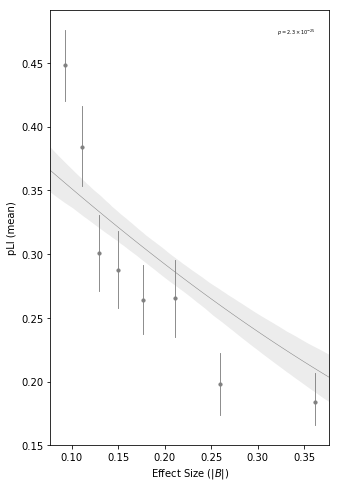

In [68]:
fig, ax = plt.subplots(1,1, figsize = (5,8))

for_plot = exac_tested[(exac_tested.sig_eqtl)]
with mpl.rc_context({"lines.linewidth": 0.5}):
    sns.regplot(for_plot.beta_corrected.abs(), for_plot.pLI, x_bins= 8, logistic = True, scatter_kws={'s': 10}, 
            line_kws={'lw': 0.5}, color = 'grey', ax = ax)
# y_pred = m.predict(exog = {'beta_abs': x1n})
# ax.plot(x1n, y_pred, c = 'green', lw = 0.1)

for_plot['beta_abs'] = for_plot.beta_corrected.abs()
m = logit('pLI ~ beta_abs + SVTYPE_NR', data= for_plot).fit()
summary = m.summary2()
summary = summary.tables[1]
p_val = summary.loc['beta_abs']['P>|z|']

ax.text(0.95, 0.95,  r"$p={0:s}$".format(mpltools.as_si(p_val, 1)), ha = 'right', va = 'center', transform=ax.transAxes,
         fontsize = 5)

ax.set_xlabel('Effect Size ($|B|$)')
ax.set_ylabel('pLI (mean)')

Optimization terminated successfully.
         Current function value: 0.544145
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.608305
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.537578
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.570764
         Iterations 6


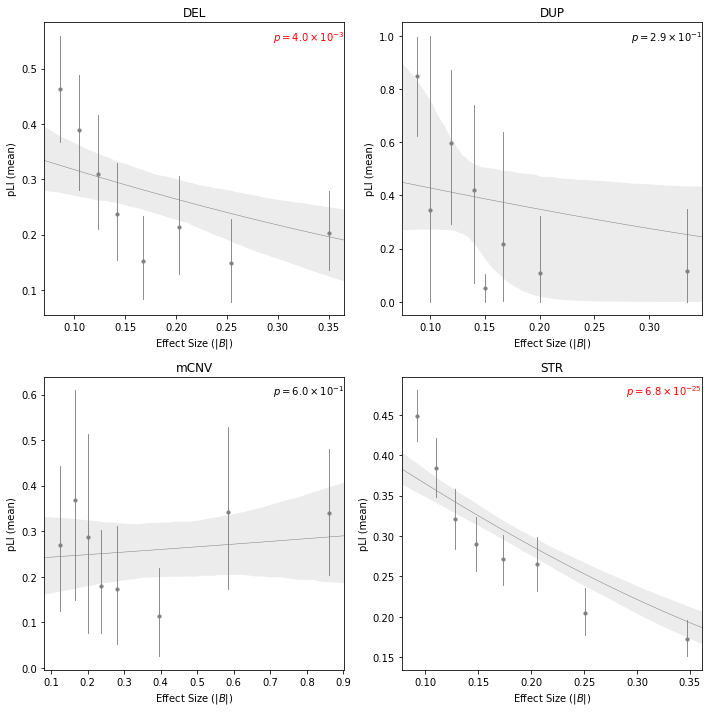

In [73]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
svtypes = ['DEL', 'DUP', 'mCNV', 'STR']
ylocs = np.arange(0.2, 1, 0.2)

axf = axes.flatten()
for i, svt in enumerate(svtypes):
    ax = axf[i]
    for_plot = exac_tested[(exac_tested.sig_eqtl) & (exac_tested.SVTYPE_NR == svt)]
    with mpl.rc_context({"lines.linewidth": 0.5}):
        sns.regplot(for_plot.beta_corrected.abs(), for_plot.pLI, x_bins= 8, 
                    logistic = True, scatter_kws={'s': 10}, label = svt, 
                line_kws={'lw': 0.5}, ax = ax, color = 'grey')
    # y_pred = m.predict(exog = {'beta_abs': x1n})
    # ax.plot(x1n, y_pred, c = 'green', lw = 0.1)

    for_plot['beta_abs'] = for_plot.beta_corrected.abs()
    m = logit('pLI ~ beta_abs + SVTYPE_NR', data= for_plot).fit()
    summary = m.summary2()
    summary = summary.tables[1]
    p_val = summary.loc['beta_abs']['P>|z|']
    c = 'black'
    if p_val < 0.05:
        c = 'red'
    ax.text(1, 0.95,  r"$p={0:s}$".format(mpltools.as_si(p_val, 1)), 
            ha = 'right', va = 'center', transform=ax.transAxes,
             fontsize = 10, color = c)

    ax.set_xlabel('Effect Size ($|B|$)')
    ax.set_ylabel('pLI (mean)')
    ax.set_title(svt)
    
plt.tight_layout()

In [ ]:
2


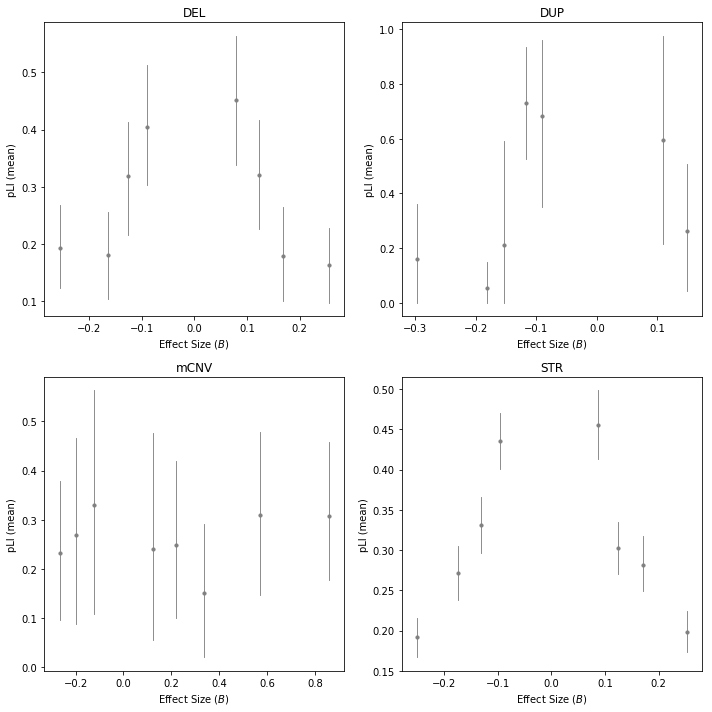

In [154]:
fig, axes = plt.subplots(2,2, figsize = (10,10))
svtypes = ['DEL', 'DUP', 'mCNV', 'STR']
ylocs = np.arange(0.2, 1, 0.2)

axf = axes.flatten()
for i, svt in enumerate(svtypes):
    ax = axf[i]
    for_plot = exac_tested[(exac_tested.sig_eqtl) & (exac_tested.SVTYPE == svt)]
    with mpl.rc_context({"lines.linewidth": 0.5}):
        sns.regplot(for_plot.beta_corrected, for_plot.pLI, x_bins= 8, fit_reg=False, 
                    scatter_kws={'s': 10}, label = svt, 
                line_kws={'lw': 0.5}, ax = ax, color = 'grey')
    # y_pred = m.predict(exog = {'beta_abs': x1n})
    # ax.plot(x1n, y_pred, c = 'green', lw = 0.1)

#     for_plot['beta_abs'] = for_plot.beta_corrected.abs()
#     m = logit('pLI ~ beta_abs + SVTYPE_NR', data= for_plot).fit()
#     summary = m.summary2()
#     summary = summary.tables[1]
#     p_val = summary.loc['beta_abs']['P>|z|']
#     c = 'black'
#     if p_val < 0.05:
#         c = 'red'
#     ax.text(1, 0.95,  r"$p={0:s}$".format(mpltools.as_si(p_val, 1)), 
#             ha = 'right', va = 'center', transform=ax.transAxes,
#              fontsize = 10, color = c)

    ax.set_xlabel('Effect Size ($B$)')
    ax.set_ylabel('pLI (mean)')
    ax.set_title(svt)
    
plt.tight_layout()